# LAB 13

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from surprise import Reader, Dataset
from surprise import SVD, SVDpp, NMF, CoClustering, SlopeOne
from surprise.model_selection import cross_validate
from tqdm.notebook import tqdm

from utils.plotting import get_context_for_dark_IDE

## Import dataset

In [2]:
def read_combined_file(path):
    df = pd.read_csv(path, header=None, names=['Cust_Id', 'Rating'], usecols=[0,1])
    df['Rating'] = df['Rating'].astype(float)
    return df

df = read_combined_file('../data/netflix/combined_data_1.txt')
print(f'Shape {df.shape}')
print('EXAMPLES')
print(df.iloc[::int(len(df)/10), :])

Shape (24058263, 2)
EXAMPLES
          Cust_Id  Rating
0              1:     NaN
2405826    582804     4.0
4811652   1654947     4.0
7217478    473884     5.0
9623304   1314869     3.0
12029130  2461301     4.0
14434956  1748183     5.0
16840782  2466682     3.0
19246608  1158806     3.0
21652434  2554585     4.0
24058260   512536     5.0


In [3]:
df1 = read_combined_file('../data/netflix/combined_data_1.txt')
df2 = read_combined_file('../data/netflix/combined_data_2.txt')
df3 = read_combined_file('../data/netflix/combined_data_3.txt')
df4 = read_combined_file('../data/netflix/combined_data_4.txt')

df = df.append(df2)
df = df.append(df3)
df = df.append(df4)
df.index = np.arange(0,len(df))

print(f'Final shape {df.shape}')

Final shape (100498277, 2)


## Add Movie Id

In [4]:
df_nan = pd.DataFrame(pd.isnull(df['Rating']))
df_nan = df_nan[df_nan['Rating']==True]
df_nan = df_nan.reset_index()
print(df_nan.head())
print(df_nan.tail())

   index  Rating
0      0    True
1    548    True
2    694    True
3   2707    True
4   2850    True
           index  Rating
17765  100488431    True
17766  100489037    True
17767  100489242    True
17768  100490605    True
17769  100497355    True


In [5]:
movie_np = np.zeros((len(df)-len(df_nan)))
movie_id = 1
start_idx = 0
for i,j in zip(df_nan['index'][:-1], df_nan['index'][1:]):
    movie_np[i-movie_id+1:j-movie_id+1] = movie_id
    movie_id += 1

last_movie_idx = df_nan.iloc[-1, 0]-movie_id
print(last_movie_idx)
movie_np[last_movie_idx:] = movie_id

print(movie_np[-10:])
# remove rows with Movie ID
df = df[pd.notnull(df['Rating'])]
print(df.shape)
print(movie_np.shape)
df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('EXAMPLES')
print(df.iloc[::int(len(df)/10), :])
print(df.dtypes)

100479585
[17770. 17770. 17770. 17770. 17770. 17770. 17770. 17770. 17770. 17770.]
(100480507, 2)
(100480507,)
EXAMPLES
           Cust_Id  Rating  Movie_Id
1          1488844     3.0         1
10050012    148824     3.0      1962
20099926    269509     2.0      3826
30149665    692661     5.0      5515
40199330   2045494     1.0      7130
50249301   1609441     4.0      9051
60299364    824825     1.0     11064
70349108   1120202     1.0     12758
80398882    325758     5.0     14482
90448563   2560266     3.0     16113
100498270   986348     4.0     17770
Cust_Id       int32
Rating      float64
Movie_Id      int32
dtype: object


## Slice dataset
Remove unpopular movies and users with low activity

In [6]:
BOTTOM_Q = 0.3

In [7]:
movies_pop = df.groupby(by='Movie_Id').agg('sum')['Rating']
with get_context_for_dark_IDE():
    movies_pop.hist()
    plt.ylabel('Count')
    plt.xlabel('Review count')
print('Movies count: ', len(movies_pop))

Movies count:  17770


Movie_Id
1         2051.0
2          516.0
3         7326.0
4          389.0
5         4468.0
          ...   
17766     1932.0
17767      749.0
17768     3867.0
17769    16861.0
17770     2596.0
Name: Rating, Length: 17770, dtype: float64
691.0
Movie_Id
2     516.0
4     389.0
7     198.0
9     249.0
11    600.0
Name: Rating, dtype: float64
Unpopular movies count:  5329


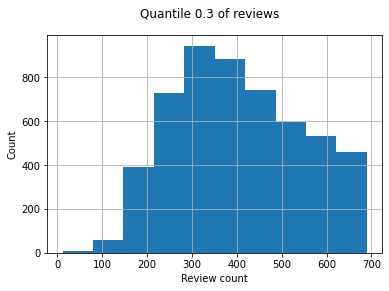

In [8]:
bottom = movies_pop.quantile(BOTTOM_Q)
print(movies_pop)
print(bottom)
unpopular_movies = movies_pop[movies_pop < bottom]
print(unpopular_movies.head())
with get_context_for_dark_IDE():
    unpopular_movies.hist()
    plt.suptitle(f'Quantile {BOTTOM_Q} of reviews')
    plt.ylabel('Count')
    plt.xlabel('Review count')

print('Unpopular movies count: ', len(unpopular_movies))
movies_to_remove = unpopular_movies.reset_index()['Movie_Id']

In [9]:
len(df[~df['Movie_Id'].isin(movies_to_remove)])


99714802

In [10]:
users_act = df.groupby(by='Cust_Id').agg('sum')['Rating']
with get_context_for_dark_IDE():
    users_act.hist()
    plt.ylabel('Count')
    plt.xlabel('User activity')

Cust_Id
6          2140.0
7          3534.0
8           413.0
10          882.0
25           94.0
            ...  
2649404     213.0
2649409     195.0
2649421     108.0
2649426    1196.0
2649429    1099.0
Name: Rating, Length: 480189, dtype: float64
169.0
Cust_Id
25      94.0
33     135.0
83     127.0
133     10.0
149     51.0
Name: Rating, dtype: float64
Users with low activity:  143301
Total users:  480189


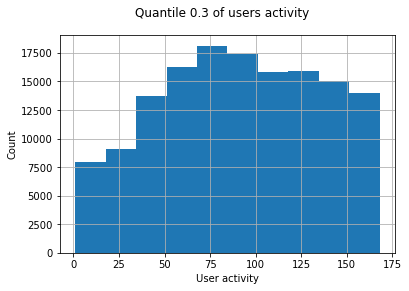

In [11]:
bottom = users_act.quantile(BOTTOM_Q)
print(users_act)
print(bottom)
low_act_users = users_act[users_act < bottom]
print(low_act_users.head())
with get_context_for_dark_IDE():
    low_act_users.hist()
    plt.suptitle(f'Quantile {BOTTOM_Q} of users activity')
    plt.ylabel('Count')
    plt.xlabel('User activity')

print('Users with low activity: ', len(low_act_users))
print('Total users: ', len(users_act))
users_to_remove = low_act_users.reset_index()['Cust_Id']

In [12]:
len(df[~df['Cust_Id'].isin(users_to_remove)])

96853586

In [13]:
len(df[~df['Cust_Id'].isin(users_to_remove) & ~df['Movie_Id'].isin(movies_to_remove)])

96120948

In [14]:
df = df[~df['Cust_Id'].isin(users_to_remove) & ~df['Movie_Id'].isin(movies_to_remove)]

In [15]:
df_title = pd.read_csv('../data/netflix/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title = df_title[~df_title['Movie_Id'].isin(movies_to_remove)]
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                              Name
Movie_Id                                          
1         2003.0                   Dinosaur Planet
3         1997.0                         Character
5         2004.0          The Rise and Fall of ECW
6         1997.0                              Sick
8         2004.0        What the #$*! Do We Know!?
10        2001.0                           Fighter
12        1947.0              My Favorite Brunette
15        1988.0  Neil Diamond: Greatest Hits Live
16        1996.0                         Screamers
17        2005.0                         7 Seconds


In [16]:
print('Ratings shape: ', df.shape)
print('Titles shape: ', df_title.shape)

Ratings shape:  (96120948, 3)
Titles shape:  (12441, 2)


## Testing SVD

In [25]:
def test_algorithm(algo):
    reader = Reader()
    df_test_sample_size = pd.DataFrame(columns=['Size', 'Err_type', 'Value'])
    df_test_time = pd.DataFrame(columns=['Size', 'Fit_time'])
    n_fold = 3
    for sample_size in tqdm([10_000, 50_000, 100_000, 200_000, 500_000, 1_000_000]):
        data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']].sample(sample_size), reader)
        res = cross_validate(algo, data, measures=['RMSE', 'MAE'], verbose=False, cv=n_fold, n_jobs=3)
        for v in res['test_rmse']:
            df_test_sample_size = df_test_sample_size.append({
                'Size': sample_size * (n_fold-1) / n_fold,
                'Err_type': 'RMSE',
                'Value': v,
                'algo': algo.__class__.__name__
            }, ignore_index=True)
        for v in res['test_mae']:
            df_test_sample_size = df_test_sample_size.append({
                'Size': sample_size * (n_fold-1) / n_fold,
                'Err_type': 'MAE',
                'Value': v,
                'algo': algo.__class__.__name__
            }, ignore_index=True)
        for t in res['fit_time']:
            df_test_time = df_test_time.append({
                'Size': sample_size * (n_fold-1) / n_fold,
                'Fit_time': t,
                'algo': algo.__class__.__name__
            }, ignore_index=True)
    return df_test_sample_size, df_test_time

def plot_results(df_test_sample_size, df_test_time):
    with get_context_for_dark_IDE():
        sns.lineplot(data=df_test_sample_size, x='Size', y='Value', hue='Err_type', markers=True)
        plt.xscale('log')
        plt.show()
        sns.lineplot(data=df_test_time, x='Size', y='Fit_time', markers=True)
        plt.xscale('log')
        plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

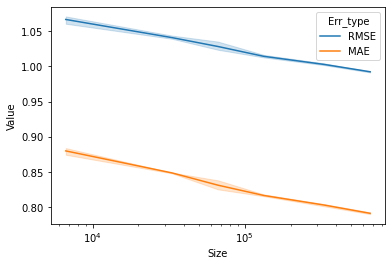

In [26]:
df_size_svd, df_time_svd = test_algorithm(SVD())
plot_results(df_size_svd, df_time_svd)

In [19]:
#data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)
#
# svd = SVD()
# cross_validate(svd, data, measures=['RMSE', 'MAE'], verbose=True, cv=3, n_jobs=-1)

## Demonstration


In [20]:
svd = SVD()
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']].sample(2_000_000), Reader())
trainset = data.build_full_trainset()
svd.fit(trainset)
movies_list = df['Movie_Id'].unique()

### Sample user reviews

In [21]:
user = df['Cust_Id'].sample().iloc[0]
user_reviews = df[df['Cust_Id'] == user].join(df_title, on='Movie_Id').sort_values(by='Rating', ascending=False)
user_reviews.head(10)

Cust_Id  Rating  Movie_Id    Year  \
218069     132511     5.0        33  2000.0   
16216629   132511     5.0      3150  2000.0   
81726923   132511     5.0     14644  2004.0   
32361485   132511     5.0      5884  1999.0   
32261884   132511     5.0      5862  2000.0   
82081086   132511     5.0     14670  1989.0   
82220246   132511     5.0     14691  1999.0   
31654975   132511     5.0      5778  1990.0   
82628618   132511     5.0     14725  1999.0   
31496532   132511     5.0      5760  2001.0   

                                                 Name  
218069                 Aqua Teen Hunger Force: Vol. 1  
16216629             Monty Python: The Life of Python  
81726923                           The Stepford Wives  
32361485  Saturday Night Live: The Best of Mike Myers  
32261884                                      Memento  
82081086                                       Batman  
82220246                                   The Matrix  
31654975                                The Godfather  
82628618        Austin Powers: The Spy Who Shagged Me  
31496532                       The Sopranos: Season 3

### Movies recomendations

In [22]:
est = [svd.predict(user, x).est for x in movies_list]
preditctions = pd.DataFrame({'Movie_Id': movies_list, 'Estimation':est}).sort_values(by='Estimation', ascending=False)
preditctions = preditctions.join(df_title, on='Movie_Id')
preditctions.head(10)


Movie_Id  Estimation    Year  \
10504     15070    4.754824  1999.0   
2429       3456    4.647131  2004.0   
2048       2942    4.563183  1999.0   
5284       7569    4.494163  2004.0   
12225     17480    4.420076  2003.0   
4936       7057    4.418931  2002.0   
3566       5092    4.416182  1997.0   
5056       7230    4.414040  2001.0   
11345     16265    4.411063  1977.0   
5682       8116    4.411042  2002.0   

                                                    Name  
10504                         Sex and the City: Season 2  
2429                                      Lost: Season 1  
2048                                   Friends: Season 6  
5284                              Dead Like Me: Season 2  
12225                               The Shield: Season 2  
4936   Lord of the Rings: The Two Towers: Extended Ed...  
3566                  Buffy the Vampire Slayer: Season 2  
5056   The Lord of the Rings: The Fellowship of the R...  
11345                  Star Wars: Episode IV: A New Hope  
5682                              The Sopranos: Season 4

## Further testing
### Matrix Factorization
documentation: <https://surprise.readthedocs.io/en/stable/matrix_factorization.html>

#### SVD Plus Plus

  0%|          | 0/6 [00:00<?, ?it/s]

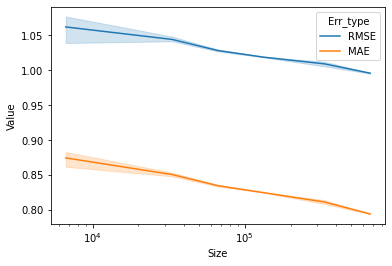

In [27]:
df_size_svdpp, df_time_svdpp = test_algorithm(SVDpp())
plot_results(df_size_svdpp, df_time_svdpp)

#### Non-negative Matrix Factorization

  0%|          | 0/6 [00:00<?, ?it/s]

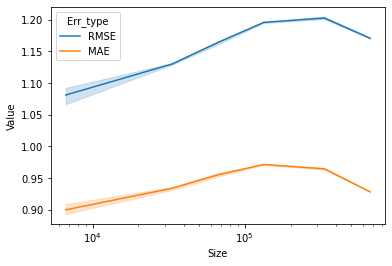

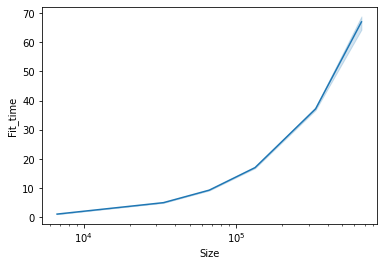

In [28]:
df_size_nmf, df_time_nmf = test_algorithm(NMF())
plot_results(df_size_nmf, df_time_nmf)

### Co-clustering
documentation:  <https://surprise.readthedocs.io/en/stable/co_clustering.html>

  0%|          | 0/6 [00:00<?, ?it/s]

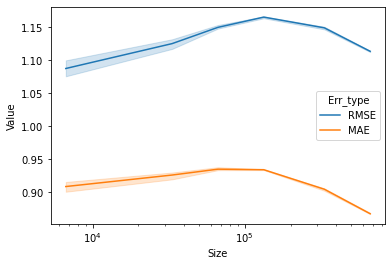

In [29]:
df_size_cc, df_time_cc = test_algorithm(CoClustering())
plot_results(df_size_cc, df_time_cc)

### SlopeOne
documentation:  <https://surprise.readthedocs.io/en/stable/slope_one.html>

In [30]:
df_size_so, df_time_so = test_algorithm(SlopeOne())
plot_results(df_size_so, df_time_so)

  0%|          | 0/6 [00:00<?, ?it/s]

### KNN family
documentation:  <https://surprise.readthedocs.io/en/stable/knn_inspired.html>
#### KNN Basic

OUT OF RAM ON 50k samples :(

In [31]:
# df_test_sample_size, df_test_time = test_algorithm(KNNBasic())
# plot_results(df_test_sample_size, df_test_time)

#### KNN With Means

OUT OF RAM ON 50k samples :(

In [32]:
# df_test_sample_size, df_test_time = test_algorithm(KNNWithMeans())
# plot_results(df_test_sample_size, df_test_time)

#### KNN Baseline

OUT OF RAM ON 50k samples :(

In [33]:
# df_test_sample_size, df_test_time = test_algorithm(KNNBaseline())
# plot_results(df_test_sample_size, df_test_time)

### Conclusion

In [34]:
df_time = df_time_svd.copy()
df_time = df_time.append(df_time_svdpp)
df_time = df_time.append(df_time_nmf)
df_time = df_time.append(df_time_cc)
df_time = df_time.append(df_time_so)


df_size = df_size_svd.copy()
df_size = df_size.append(df_size_svdpp)
df_size = df_size.append(df_size_nmf)
df_size = df_size.append(df_size_cc)
df_size = df_size.append(df_size_so)


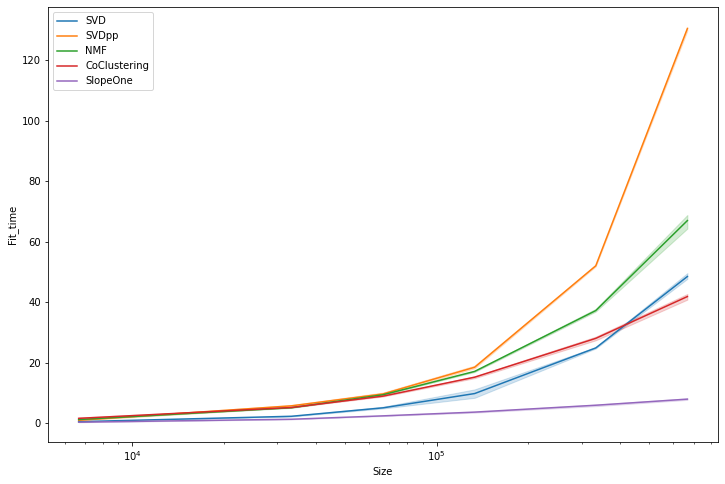

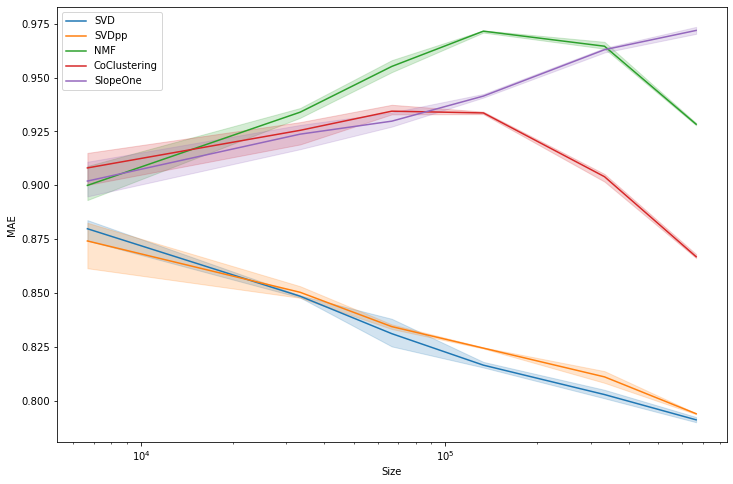

In [43]:
with get_context_for_dark_IDE():
    plt.figure(figsize=(12,8))
    sns.lineplot(data=df_time, x='Size', y='Fit_time', hue='algo', markers=True)
    plt.xscale('log')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,8))
    sns.lineplot(data=df_size[df_size['Err_type'] == 'RMSE'], x='Size', y='Value', hue='algo', markers=True)
    plt.ylabel('RMSE')
    plt.xscale('log')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,8))
    sns.lineplot(data=df_size[df_size['Err_type'] == 'MAE'], x='Size', y='Value', hue='algo', markers=True)
    plt.ylabel('MAE')
    plt.xscale('log')
    plt.legend()
    plt.show()